## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [6]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [7]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [8]:
#label for 0 is 10, change to 0 the label for 0

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

## Extract a random validation set from the training set
In this case the size of the validation set is 10% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [9]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 3), (7325, 32, 32, 3), (65932, 1), (7325, 1))

## Visualize the images

In [10]:
#Function to visualize image with their respective labels
def plot_img(images, labels, images_number=4):
    plt.figure(figsize=(8,8))
    for i in range(images_number**2):
        plt.subplot(images_number, images_number, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,:], cmap=plt.cm.binary)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

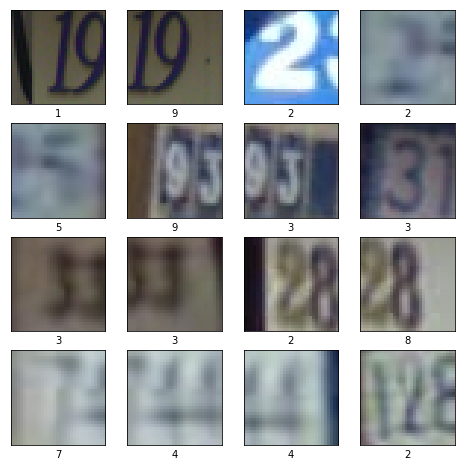

In [11]:
#Check if the training set is divided correctely and print the data
plot_img(train_img, train_lbs)

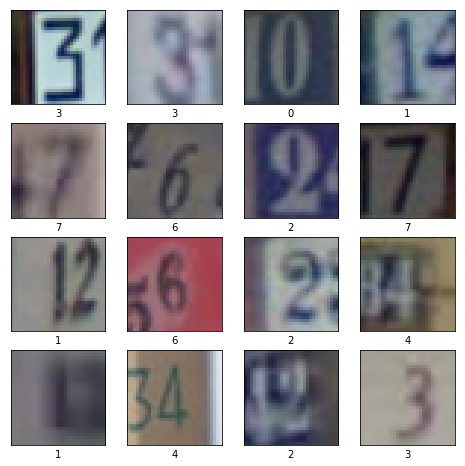

In [12]:
#Check if the validation set is divided correctely and print the data
plot_img(validation_img, validation_lbs)

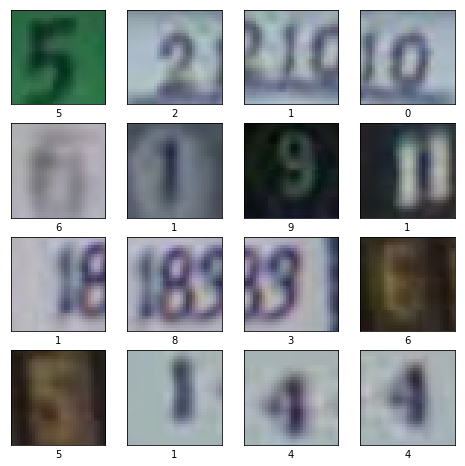

In [13]:
plot_img(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [10]:
train_img = train_img.astype(float)
test_img = test_img.astype(float)
validation_img = validation_img.astype(float)

In [11]:
def calculate_mean(train_img):
    #zero center across each colour channel
    rmean = np.mean(train_img[:,:,:,0])
    bmean = np.mean(train_img[:,:,:,1])
    gmean = np.mean(train_img[:,:,:,2])
    
    return rmean, bmean, gmean

def calculate_std_dev(train_img):
    #normalize by dividing each dimension colour channel by its standard deviation
    rstd = np.std(train_img[:,:,:,0])
    bstd = np.std(train_img[:,:,:,1])
    gstd = np.std(train_img[:,:,:,2])
    
    return rstd, bstd, gstd

In [12]:
def normalize_data(train_img, validation_img=None, test_img=None, validation=False, test=False):
    #cast to float otherwise during mean subtraction floats would be casted to ints
    
    rmean, bmean, gmean = calculate_mean(train_img)
    
    train_img[:,:,:,0] = train_img[:,:,:,0]-rmean
    train_img[:,:,:,1] = train_img[:,:,:,1]-bmean
    train_img[:,:,:,2] = train_img[:,:,:,2]-gmean

    rstd, bstd, gstd = calculate_std_dev(train_img)
    
    train_img[:,:,:,0] = train_img[:,:,:,0]/rstd
    train_img[:,:,:,1] = train_img[:,:,:,1]/bstd
    train_img[:,:,:,2] = train_img[:,:,:,2]/gstd

    if test == True:
        test_img[:,:,:,0] = test_img[:,:,:,0]-rmean
        test_img[:,:,:,1] = test_img[:,:,:,1]-bmean
        test_img[:,:,:,2] = test_img[:,:,:,2]-gmean

        test_img[:,:,:,0] = test_img[:,:,:,0]/rstd
        test_img[:,:,:,1] = test_img[:,:,:,1]/bstd
        test_img[:,:,:,2] = test_img[:,:,:,2]/gstd
    
    if validation == True:
        validation_img[:,:,:,0] = validation_img[:,:,:,0]-rmean
        validation_img[:,:,:,1] = validation_img[:,:,:,1]-bmean
        validation_img[:,:,:,2] = validation_img[:,:,:,2]-gmean

        validation_img[:,:,:,0] = validation_img[:,:,:,0]/rstd
        validation_img[:,:,:,1] = validation_img[:,:,:,1]/bstd
        validation_img[:,:,:,2] = validation_img[:,:,:,2]/gstd

In [13]:
normalize_data(train_img, validation_img, test_img, validation=True, test=True)

## Hyper-parameters Optimization

In [9]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

Here are defined a few things that will be usefull during the training:
 - the number of epochs the training algorithm will run
 - a function that allows to save the trained model in a file every three epochs (usefull if you don't want to run the training again)
 - a function that defines the decay of the learning rate
 - a function that plots validation statistics

In [14]:
#train on 6 epochs
epoch_num = 6

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#learning rate decay call back    
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [31]:
#define function to plot accuracy or loss
def plot_validation(number_of_models, history, loss=False):
    name, key, loc, f = 'Accuracy', 'acc', 'upper left', max
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(history[i].history['val_'+key], label='val_'+key+str(i))
        print("CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}".format(
            i,epoch_num,name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='upper left')
    plt.show()

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

In [16]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    else:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/structure/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 24s 366us/sample - loss: 0.7436 - acc: 0.7783 - val_loss: 0.4761 - val_acc: 0.8670
Epoch 2/6
65932/65932 [==============================] - 25s 384us/sample - loss: 0.4104 - acc: 0.8825 - val_loss: 0.4000 - val_acc: 0.8822
Epoch 3/6
65932/65932 [==============================] - 25s 376us/sample - loss: 0.3242 - acc: 0.9045 - val_loss: 0.3838 - val_acc: 0.8883
Epoch 4/6
65932/65932 [==============================] - 25s 385us/sample - loss: 0.2668 - acc: 0.9214 - val_loss: 0.3666 - val_acc: 0.8923
Epoch 5/6
65932/65932 [==============================] - 25s 385us/sample - loss: 0.2203 - acc: 0.9356 - val_loss: 0.3634 - val_acc: 0.8999
Epoch 6/6
65932/65932 [==============================] - 24s 369us/sample - loss: 0.1800 - acc: 0.9485 - val_loss: 0.3722 - val_acc: 0.8991
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 36s 5

CNN 0: Epochs=6, Train Accuracy=0.94852, Validation Accuracy=0.89993
CNN 1: Epochs=6, Train Accuracy=0.95750, Validation Accuracy=0.90894


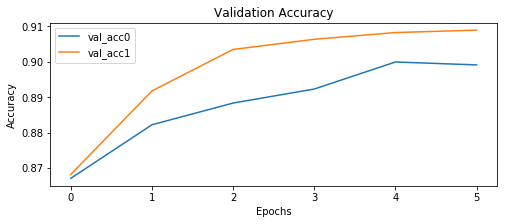

CNN 0: Epochs=6, Train Loss=0.18004, Validation Loss=0.36343
CNN 1: Epochs=6, Train Loss=0.14505, Validation Loss=0.30608


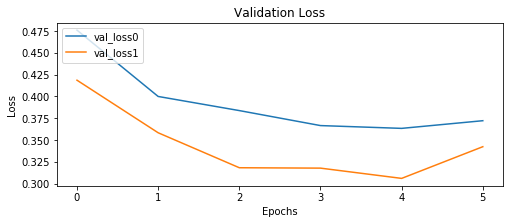

In [18]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The second model (without max pooling) performs better.

### Validate the number of covolutional layers

In [12]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [13]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/layers/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 25s 380us/sample - loss: 0.5322 - acc: 0.8496 - val_loss: 0.4543 - val_acc: 0.8724
Epoch 2/6
65932/65932 [==============================] - 25s 372us/sample - loss: 0.3767 - acc: 0.8904 - val_loss: 0.3910 - val_acc: 0.8838
Epoch 3/6
65932/65932 [==============================] - 24s 358us/sample - loss: 0.2987 - acc: 0.9121 - val_loss: 0.3676 - val_acc: 0.8927
Epoch 4/6
65932/65932 [==============================] - 23s 353us/sample - loss: 0.2431 - acc: 0.9287 - val_loss: 0.3583 - val_acc: 0.8958
Epoch 5/6
65932/65932 [==============================] - 24s 358us/sample - loss: 0.1965 - acc: 0.9434 - val_loss: 0.3689 - val_acc: 0.8979
Epoch 6/6
65932/65932 [==============================] - 23s 355us/sample - loss: 0.1554 - acc: 0.9549 - val_loss: 0.4020 - val_acc: 0.8926
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 34s 5

CNN 0: Epochs=6, Train Accuracy=0.95488, Validation Accuracy=0.89788
CNN 1: Epochs=6, Train Accuracy=0.95859, Validation Accuracy=0.91290
CNN 2: Epochs=6, Train Accuracy=0.95814, Validation Accuracy=0.90580
CNN 3: Epochs=6, Train Accuracy=0.95480, Validation Accuracy=0.90594
CNN 4: Epochs=6, Train Accuracy=0.94902, Validation Accuracy=0.91031
CNN 5: Epochs=6, Train Accuracy=0.95539, Validation Accuracy=0.91427
CNN 6: Epochs=6, Train Accuracy=0.95133, Validation Accuracy=0.91795


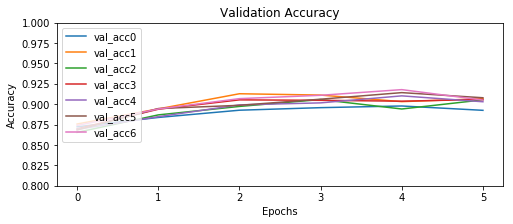

CNN 0: Epochs=6, Train Loss=0.15536, Validation Loss=0.35834
CNN 1: Epochs=6, Train Loss=0.13877, Validation Loss=0.29768
CNN 2: Epochs=6, Train Loss=0.14385, Validation Loss=0.33374
CNN 3: Epochs=6, Train Loss=0.15026, Validation Loss=0.31934
CNN 4: Epochs=6, Train Loss=0.17215, Validation Loss=0.31747
CNN 5: Epochs=6, Train Loss=0.15032, Validation Loss=0.31724
CNN 6: Epochs=6, Train Loss=0.16335, Validation Loss=0.29192


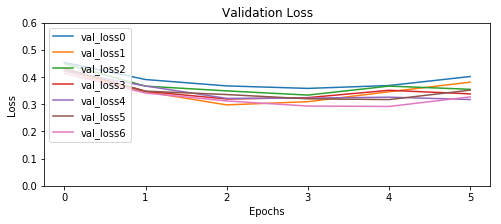

In [14]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The second and seventh model perform almost equally, but the second has less parameters, therefore it will be chosen.

In [82]:
val_models[1].summary()
val_models[6].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_294 (Conv2D)          (None, 32, 32, 24)        672       
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 32, 32, 24)        5208      
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 15, 15, 24)        5208      
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 15, 15, 48)        10416     
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 15, 15, 48)        20784     
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 7, 7, 16)          6928      
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 7, 7, 64)          9280      
__________

### Validate the number of filters per layer

In [19]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(8+8*i, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [20]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/filters/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 20s 301us/sample - loss: 0.8153 - acc: 0.7427 - val_loss: 0.5340 - val_acc: 0.8313
Epoch 2/6
65932/65932 [==============================] - 21s 312us/sample - loss: 0.4272 - acc: 0.8722 - val_loss: 0.4415 - val_acc: 0.8642
Epoch 3/6
65932/65932 [==============================] - 21s 316us/sample - loss: 0.3401 - acc: 0.8987 - val_loss: 0.3798 - val_acc: 0.8837
Epoch 4/6
65932/65932 [==============================] - 19s 293us/sample - loss: 0.2832 - acc: 0.9149 - val_loss: 0.3668 - val_acc: 0.8930
Epoch 5/6
65932/65932 [==============================] - 19s 293us/sample - loss: 0.2405 - acc: 0.9284 - val_loss: 0.3563 - val_acc: 0.8958
Epoch 6/6
65932/65932 [==============================] - 19s 293us/sample - loss: 0.2034 - acc: 0.9391 - val_loss: 0.3622 - val_acc: 0.8954
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 38s 5

CNN 0: Epochs=6, Train Accuracy=0.93912, Validation Accuracy=0.89584
CNN 1: Epochs=6, Train Accuracy=0.95356, Validation Accuracy=0.90894
CNN 2: Epochs=6, Train Accuracy=0.96104, Validation Accuracy=0.91249
CNN 3: Epochs=6, Train Accuracy=0.96932, Validation Accuracy=0.91481
CNN 4: Epochs=6, Train Accuracy=0.96232, Validation Accuracy=0.91563


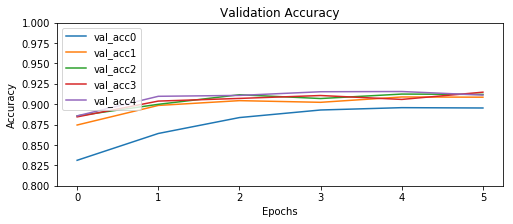

CNN 0: Epochs=6, Train Loss=0.20337, Validation Loss=0.35631
CNN 1: Epochs=6, Train Loss=0.15514, Validation Loss=0.31755
CNN 2: Epochs=6, Train Loss=0.13055, Validation Loss=0.29741
CNN 3: Epochs=6, Train Loss=0.10231, Validation Loss=0.29587
CNN 4: Epochs=6, Train Loss=0.12663, Validation Loss=0.29985


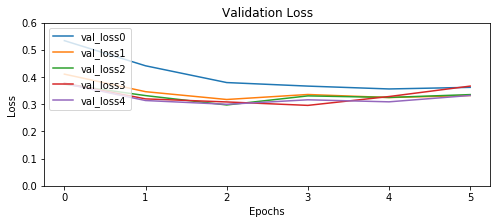

In [21]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The thrid model, with 32 and 64 filters exhibits better performances.

In [ ]:
val_models[2].summary()

### Validate the neurons in the fully connected layer

In [32]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64+64*(i), activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [35]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/FC/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 85s 1ms/sample - loss: 0.1535 - acc: 0.9542 - val_loss: 0.3224 - val_acc: 0.9149
Epoch 2/6
25344/65932 [==========>...................] - ETA: 50s - loss: 0.1138 - acc: 0.9665

KeyboardInterrupt: 

In [39]:
val_errors.append(val_models[5].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 93s 1ms/sample - loss: 0.6910 - acc: 0.7788 - val_loss: 0.3713 - val_acc: 0.8872
Epoch 2/6
65932/65932 [==============================] - 93s 1ms/sample - loss: 0.3037 - acc: 0.9097 - val_loss: 0.3000 - val_acc: 0.9078
Epoch 3/6
65932/65932 [==============================] - 89s 1ms/sample - loss: 0.2271 - acc: 0.9327 - val_loss: 0.3041 - val_acc: 0.9125
Epoch 4/6
65932/65932 [==============================] - 86s 1ms/sample - loss: 0.1698 - acc: 0.9503 - val_loss: 0.3069 - val_acc: 0.9149
Epoch 5/6
65932/65932 [==============================] - 94s 1ms/sample - loss: 0.1175 - acc: 0.9651 - val_loss: 0.3494 - val_acc: 0.9156
Epoch 6/6
65932/65932 [==============================] - 91s 1ms/sample - loss: 0.0837 - acc: 0.9750 - val_loss: 0.3931 - val_acc: 0.9092


CNN 0: Epochs=6, Train Accuracy=0.95642, Validation Accuracy=0.91645
CNN 1: Epochs=6, Train Accuracy=0.96348, Validation Accuracy=0.91686
CNN 2: Epochs=6, Train Accuracy=0.97149, Validation Accuracy=0.91440
CNN 3: Epochs=6, Train Accuracy=0.97048, Validation Accuracy=0.92014
CNN 4: Epochs=6, Train Accuracy=0.95413, Validation Accuracy=0.90744


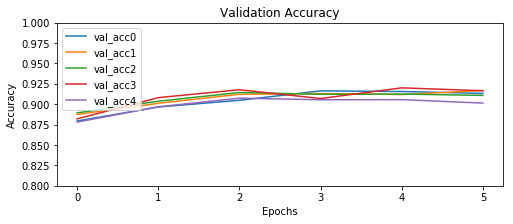

CNN 0: Epochs=6, Train Loss=0.14872, Validation Loss=0.28424
CNN 1: Epochs=6, Train Loss=0.12285, Validation Loss=0.29028
CNN 2: Epochs=6, Train Loss=0.09292, Validation Loss=0.28956
CNN 3: Epochs=6, Train Loss=0.09920, Validation Loss=0.27567
CNN 4: Epochs=6, Train Loss=0.16001, Validation Loss=0.30874


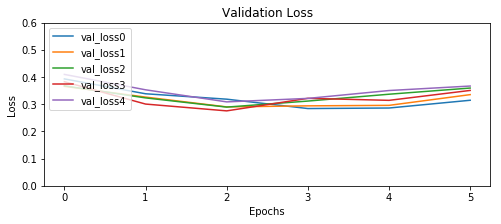

In [40]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

In [29]:
val_models[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_24 (Flatten)         (None, 3136)              0         
__________

### Validate droput

In [45]:
val_models = []

droput = [0.1,0.2,0.3,0.4,0.5,0.6]

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(droput[i]))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [46]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/dropout/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 90s 1ms/sample - loss: 0.7372 - acc: 0.7619 - val_loss: 0.3588 - val_acc: 0.8915
Epoch 2/6
65932/65932 [==============================] - 90s 1ms/sample - loss: 0.3163 - acc: 0.9066 - val_loss: 0.3057 - val_acc: 0.9098
Epoch 3/6
65932/65932 [==============================] - 95s 1ms/sample - loss: 0.2440 - acc: 0.9276 - val_loss: 0.2843 - val_acc: 0.9162
Epoch 4/6
65932/65932 [==============================] - 89s 1ms/sample - loss: 0.1910 - acc: 0.9444 - val_loss: 0.2958 - val_acc: 0.9180
Epoch 5/6
65932/65932 [==============================] - 87s 1ms/sample - loss: 0.1491 - acc: 0.9568 - val_loss: 0.3050 - val_acc: 0.9175
Epoch 6/6
65932/65932 [==============================] - 88s 1ms/sample - loss: 0.1150 - acc: 0.9655 - val_loss: 0.3196 - val_acc: 0.9240
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 89s 1ms/sample - 

CNN 0: Epochs=6, Train Accuracy=0.96546, Validation Accuracy=0.92396
CNN 1: Epochs=6, Train Accuracy=0.96164, Validation Accuracy=0.92437
CNN 2: Epochs=6, Train Accuracy=0.95571, Validation Accuracy=0.92341
CNN 3: Epochs=6, Train Accuracy=0.95042, Validation Accuracy=0.92191
CNN 4: Epochs=6, Train Accuracy=0.94062, Validation Accuracy=0.92191
CNN 5: Epochs=6, Train Accuracy=0.93668, Validation Accuracy=0.91891


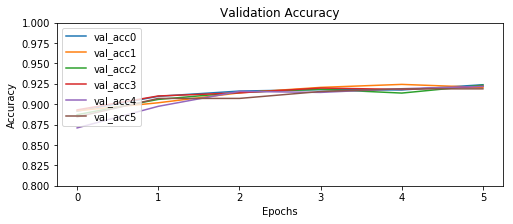

CNN 0: Epochs=6, Train Loss=0.11500, Validation Loss=0.28431
CNN 1: Epochs=6, Train Loss=0.12954, Validation Loss=0.27682
CNN 2: Epochs=6, Train Loss=0.14808, Validation Loss=0.28442
CNN 3: Epochs=6, Train Loss=0.16455, Validation Loss=0.27555
CNN 4: Epochs=6, Train Loss=0.20209, Validation Loss=0.27252
CNN 5: Epochs=6, Train Loss=0.21783, Validation Loss=0.28784


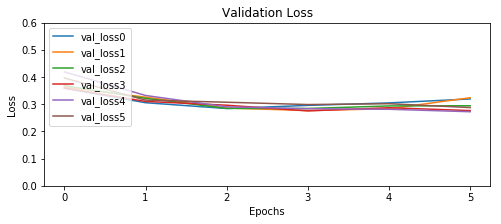

In [47]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

In [51]:
val_models[4].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_300 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_303 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_50 (Flatten)         (None, 3136)              0         
__________

### Validate the batch size

In [57]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [58]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/batch/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=24+24*i, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 106s 2ms/sample - loss: 0.8314 - acc: 0.7292 - val_loss: 0.3848 - val_acc: 0.8829
Epoch 2/6
65932/65932 [==============================] - 106s 2ms/sample - loss: 0.3784 - acc: 0.8885 - val_loss: 0.3239 - val_acc: 0.9033
Epoch 3/6
65932/65932 [==============================] - 112s 2ms/sample - loss: 0.3156 - acc: 0.9081 - val_loss: 0.3056 - val_acc: 0.9128
Epoch 4/6
65932/65932 [==============================] - 106s 2ms/sample - loss: 0.2724 - acc: 0.9185 - val_loss: 0.3137 - val_acc: 0.9062
Epoch 5/6
65932/65932 [==============================] - 105s 2ms/sample - loss: 0.2423 - acc: 0.9284 - val_loss: 0.3048 - val_acc: 0.9103
Epoch 6/6
65932/65932 [==============================] - 99s 2ms/sample - loss: 0.2125 - acc: 0.9364 - val_loss: 0.3007 - val_acc: 0.9186
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 92s 1ms/samp

CNN 0: Epochs=6, Train Accuracy=0.93642, Validation Accuracy=0.91863
CNN 1: Epochs=6, Train Accuracy=0.94064, Validation Accuracy=0.92328
CNN 2: Epochs=6, Train Accuracy=0.94194, Validation Accuracy=0.92410
CNN 3: Epochs=6, Train Accuracy=0.93945, Validation Accuracy=0.92123
CNN 4: Epochs=6, Train Accuracy=0.94297, Validation Accuracy=0.92068
CNN 5: Epochs=6, Train Accuracy=0.93718, Validation Accuracy=0.92000


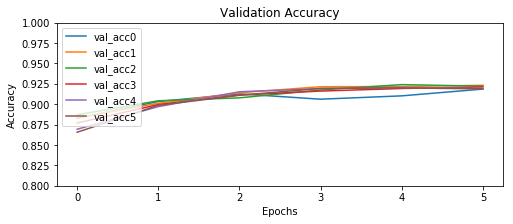

CNN 0: Epochs=6, Train Loss=0.21248, Validation Loss=0.30070
CNN 1: Epochs=6, Train Loss=0.20307, Validation Loss=0.26719
CNN 2: Epochs=6, Train Loss=0.19832, Validation Loss=0.25939
CNN 3: Epochs=6, Train Loss=0.20280, Validation Loss=0.28421
CNN 4: Epochs=6, Train Loss=0.19431, Validation Loss=0.27300
CNN 5: Epochs=6, Train Loss=0.21552, Validation Loss=0.27634


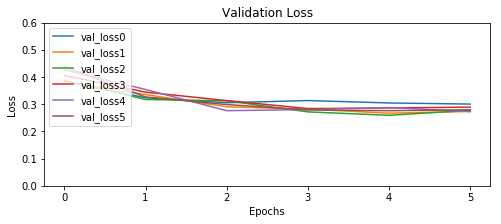

In [59]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

In [12]:
best_batch_size = 72

### Validate Learning rate

In [16]:
#learning rate decay call back    

val_models = []

models_number = 5

for i in range(models_number):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [17]:
#create multiple learning rates
def lrd(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**-3 * (0.65 - (0.025*i )) ** x, verbose=0)

In [18]:
#validate models
val_errors = []


#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './validation/learning_rate/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=best_batch_size, epochs=epoch_num+2+(i),
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)), lrd(i)]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/8
65932/65932 [==============================] - 142s 2ms/sample - loss: 0.8025 - acc: 0.7423 - val_loss: 0.3625 - val_acc: 0.8919
Epoch 2/8
65932/65932 [==============================] - 149s 2ms/sample - loss: 0.3474 - acc: 0.8982 - val_loss: 0.3003 - val_acc: 0.9055
Epoch 3/8
65932/65932 [==============================] - 149s 2ms/sample - loss: 0.2701 - acc: 0.9206 - val_loss: 0.2628 - val_acc: 0.9231
Epoch 4/8
65932/65932 [==============================] - 148s 2ms/sample - loss: 0.2221 - acc: 0.9364 - val_loss: 0.2544 - val_acc: 0.9271
Epoch 5/8
65932/65932 [==============================] - 148s 2ms/sample - loss: 0.1857 - acc: 0.9468 - val_loss: 0.2612 - val_acc: 0.9264
Epoch 6/8
65932/65932 [==============================] - 147s 2ms/sample - loss: 0.1597 - acc: 0.9548 - val_loss: 0.2587 - val_acc: 0.9267
Epoch 7/8
65932/65932 [==============================] - 147s 2ms/sample - loss: 0.1424 - acc: 0.9600 - val_loss: 0.2

CNN 0: Epochs=6, Train Accuracy=0.96351, Validation Accuracy=0.93010
CNN 1: Epochs=6, Train Accuracy=0.95718, Validation Accuracy=0.92956
CNN 2: Epochs=6, Train Accuracy=0.96217, Validation Accuracy=0.93024
CNN 3: Epochs=6, Train Accuracy=0.95683, Validation Accuracy=0.92833
CNN 4: Epochs=6, Train Accuracy=0.95254, Validation Accuracy=0.92683


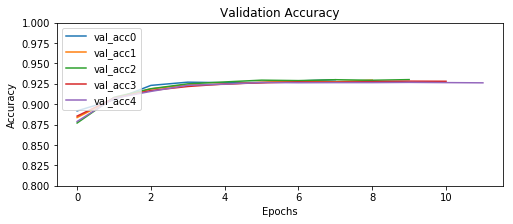

CNN 0: Epochs=6, Train Loss=0.13087, Validation Loss=0.25438
CNN 1: Epochs=6, Train Loss=0.15384, Validation Loss=0.26094
CNN 2: Epochs=6, Train Loss=0.13253, Validation Loss=0.25948
CNN 3: Epochs=6, Train Loss=0.15524, Validation Loss=0.25967
CNN 4: Epochs=6, Train Loss=0.16788, Validation Loss=0.27297


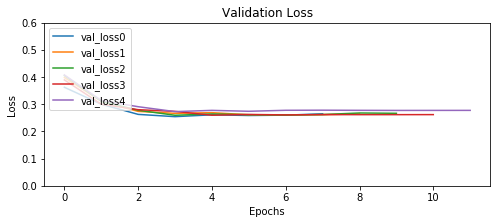

In [19]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The first model is the better performing one.

### Train the model on the whole training set (train + validation renormalized)

In [19]:
def lrd(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**-3 * (0.65 - (0.025*i )) ** x, verbose=0)

In [20]:
best_lr = lrd(0)

In [21]:
best_batch_size = 72

In [22]:
#reload the datasets and renormalize them, without splitting the validation set.
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [23]:
train_img = train_img.astype(float)
test_img = test_img.astype(float)

normalize_data(train_img, test_img = test_img, test=True)

In [24]:
#create the final model
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), strides=2, activation='relu'))
    
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './training/model'
os.makedirs(base_name, exist_ok=True)

#train it
history = model.fit(train_img, train_lbs, batch_size=best_batch_size, epochs=9, validation_data=(test_img, test_lbs),
                    verbose = 1, callbacks=[checkpoint(base_name), best_lr])

Train on 73257 samples, validate on 26032 samples
Epoch 1/9
73257/73257 [==============================] - 188s 3ms/sample - loss: 0.8191 - acc: 0.7357 - val_loss: 0.3889 - val_acc: 0.8848
Epoch 2/9
73257/73257 [==============================] - 194s 3ms/sample - loss: 0.3452 - acc: 0.8990 - val_loss: 0.3184 - val_acc: 0.9092
Epoch 3/9
73257/73257 [==============================] - 193s 3ms/sample - loss: 0.2714 - acc: 0.9221 - val_loss: 0.2844 - val_acc: 0.9196
Epoch 4/9
73257/73257 [==============================] - 192s 3ms/sample - loss: 0.2234 - acc: 0.9365 - val_loss: 0.2707 - val_acc: 0.9250
Epoch 5/9
73257/73257 [==============================] - 193s 3ms/sample - loss: 0.1912 - acc: 0.9460 - val_loss: 0.2724 - val_acc: 0.9282
Epoch 6/9
73257/73257 [==============================] - 191s 3ms/sample - loss: 0.1683 - acc: 0.9525 - val_loss: 0.2704 - val_acc: 0.9294
Epoch 7/9
73257/73257 [==============================] - 193s 3ms/sample - loss: 0.1522 - acc: 0.9571 - val_loss: 0.

CNN 0: Epochs=6, Train Accuracy=0.96362, Validation Accuracy=0.93174


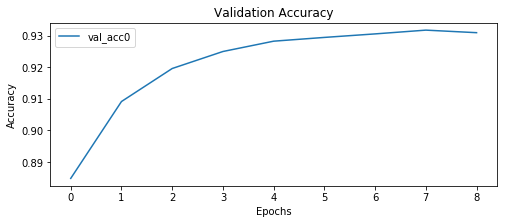

CNN 0: Epochs=6, Train Loss=0.13200, Validation Loss=0.27043


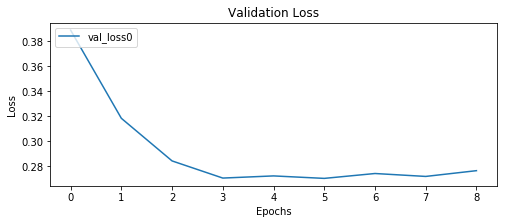

In [32]:
plot_validation(1, [history])

plot_validation(1, [history], loss=True)

In [27]:
model.evaluate(test_img, test_lbs)

26032/26032 [==============================] - 19s 711us/sample - loss: 0.2766 - acc: 0.9309


[0.27659214862774584, 0.93093115]